<a href="https://colab.research.google.com/github/desmond-rn/projet-inverse-2d/blob/master/src/notebook/format_binaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression

In [86]:
%reset -f

In [87]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
# import keras
import tensorflow as tf
from tensorflow import keras
import random
import sklearn
import struct
from keras import backend as K

from ast import literal_eval as l_eval

In [88]:
# from keras import layers
# from keras import models
# from keras import utils 
# from keras import losses
# from keras import metrics
# from keras import optimizers
# from keras import backend as K
from sklearn import metrics
from IPython.display import Image

In [89]:
np.set_printoptions(precision = 3)

## Récupérons les données

In [90]:
""" DEPUIS GOOGLE DRIVE """
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [91]:
%cd ~
%cd /gdrive/My\ Drive
%cd Colab\ Notebooks/Problème\ Inverse/2D\ VNet
print()

%ls

/root
/gdrive/My Drive
/gdrive/My Drive/Colab Notebooks/Problème Inverse/2D VNet

Apprentissage.ipynb  legacy/  test/  train/  val/  Vnet2d.jpg


In [92]:
# %ls
# X_train = np.load("../data/inversePB/train/X.npy")
# Y_train = np.load("../data/inversePB/train/Y.npy")

X_train = np.load("train/X.npy")
Y_train = np.load("train/Y.npy")

print("shapes", X_train.shape, Y_train.shape)

shapes (300, 64, 64, 48) (300, 64, 64, 1)


In [93]:
# X_val, Y_val = X_train, Y_train
# X_test, Y_test = X_train, Y_train
# X_val = np.load("../data/inversePB/val/X.npy")
# Y_val = np.load("../data/inversePB/val/Y.npy")

X_val = np.load("val/X.npy")
Y_val = np.load("val/Y.npy")

print("shapes", X_val.shape, Y_val.shape)

shapes (100, 64, 64, 48) (100, 64, 64, 1)


In [94]:
# X_test = np.load("../data/inversePB/test/X.npy")
# Y_test = np.load("../data/inversePB/test/Y.npy")

X_test = np.load("test/X.npy")
Y_test = np.load("test/Y.npy")

print("shapes", X_test.shape, Y_test.shape)
Y_test = Y_test[:,:,:,0]    ## derniere dimension inutile

shapes (82, 64, 64, 48) (82, 64, 64, 1)


## Le Vnet

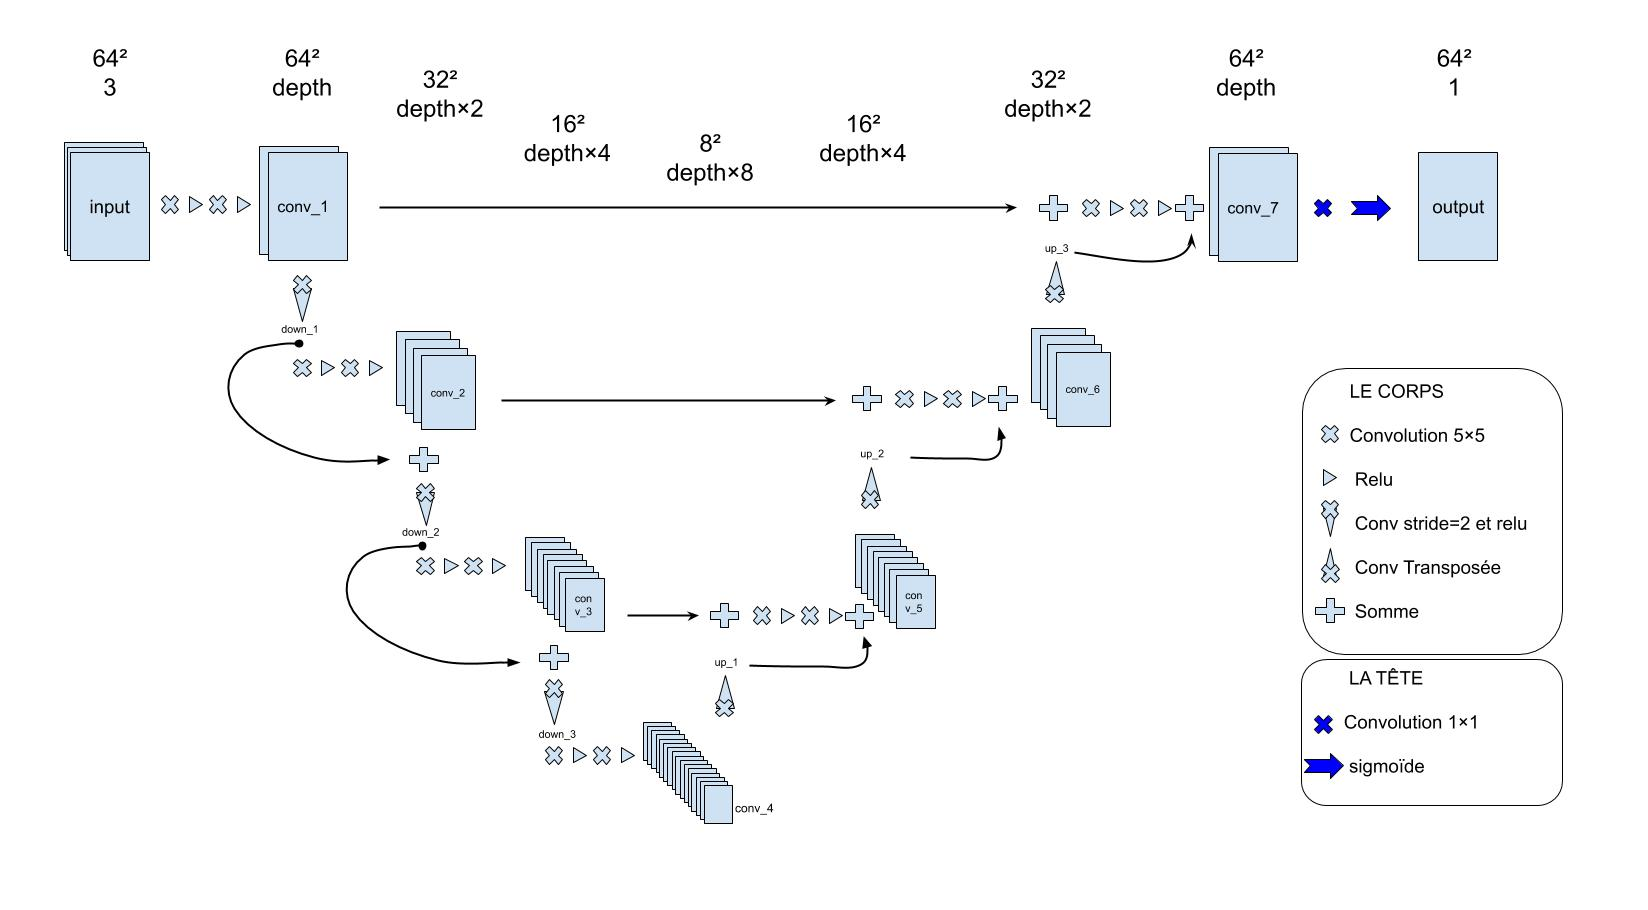

In [95]:
Image("Vnet2d.jpg",width="800")

In [96]:
Conv=tf.keras.layers.Conv2D
UpSampling=tf.keras.layers.UpSampling2D
SpatialDropout= tf.keras.layers.SpatialDropout2D

class VNet:
    
    def __init__(self,
                 input_shape,
                 nb_classes, 
                 levels=3,                      ## Super on peut choisir le nombre de levels
                 depth=2, 
                 kernel_size=3, 
                 up_kernel_size=3, 
                 activation="relu",
                 batch_norm=True,
                 dropout_rate=0, 
                 ): 


        self.input_shape=input_shape
        self.nb_classes=nb_classes
        self.levels = levels
        self.depth = depth
        self.kernel_size = kernel_size
        self.up_kernel_size = up_kernel_size
        self.activation = activation
        self.batch_norm=batch_norm
        self.dropout_rate = dropout_rate

        assert len(input_shape)==3

        inputs= tf.keras.Input(shape=input_shape)
        logits= self.body(inputs)
        if self.nb_classes==1:
            outputs= Conv(1,1,activation="sigmoid")(logits)
        else:
            outputs= Conv(nb_classes,1,activation="softmax")(logits)

        self.model = tf.keras.Model(inputs=inputs, outputs=outputs)

        
    def doubleConv(self, Y, depth):
        Y = Conv(depth, self.kernel_size,activation=self.activation,padding='same')(Y)
        Y = Conv(depth, self.kernel_size,activation=self.activation,padding='same')(Y)
        if self.batch_norm:
            Y = tf.keras.layers.BatchNormalization()(Y)
        if self.dropout_rate>0:                             ## S'il n'ya pas de dropout on ne fait rien
            Y = SpatialDropout(self.dropout_rate)(Y)        ## Dans le SpatialDropout, si on cache une portion de l'image, on la cahe totalement !!! pas la peine de chacher seulement certains neurones 
        return Y

    def makeDown(self, Y, depth):
        down = Conv(depth, 2, strides=2,padding="same")(Y)
        return down

    def makeUp(self, Y, depth):
        Y = UpSampling()(Y)
        up = Conv(depth, self.up_kernel_size,activation=self.activation, padding="same",
                                    kernel_initializer=tf.keras.initializers.Constant(value=1/self.up_kernel_size/depth))(Y)      ## Noyaux de lissage pour avoir une moyenne a 1 ?
        return up

        
    def body(self,inputs):
        left = {}
        left[0] = self.doubleConv(inputs,self.depth)
        print("left[0].shape=",left[0].shape)
        for i in range(1, self.levels):                           ## une boucle pour la descente
            down = self.makeDown(left[i-1], self.depth*2**i)
            conv = self.doubleConv(down, self.depth*2**i)
            left[i] = tf.keras.layers.Add()([down, conv])         ## l'addition c'est comme le racourcis dans le resnet ## essayons les multiplications
            if i<self.levels-1:
                print(f"left[{i}].shape=",left[i].shape)

        central = left[self.levels-1]
        print(f"central.shape=",central.shape)

        right=central
        for i in range(self.levels-2, -1,-1):                     ## une boucle pour la remontée
            up = self.makeUp(right, self.depth*2**i)
            add = tf.keras.layers.Add()([left[i], up])
            conv = self.doubleConv(add, self.depth*2**i)
            right = tf.keras.layers.Add()([up, conv])
            print(f"right[{i}].shape=",right.shape)

        return right

    @tf.function                                              ## Pour accelerer le code
    def __call__(self,inputs):
        return self.model(inputs)

In [97]:
levels =  5#@param {type:"integer"}
depth =  24#@param {type:"integer"}
kernel_size =  5#@param {type:"integer"}
up_kernel_size =  3#@param {type:"integer"}
activation = 'relu' #@param ['softplus', 'relu', 'sigmoid', 'tanh']
batch_norm = True #@param {type:"boolean"}
dropout_rate = 0.0 #@param {type:"number"}
nb_cat = 1

run_functions_eagerly = False #@param {type:"boolean"}

tf.config.run_functions_eagerly(run_functions_eagerly)

input_shape=(64,64,48)

model=VNet(input_shape,
           nb_cat,
           levels,
           depth,
           kernel_size,
           up_kernel_size,
           activation,
           batch_norm,
           dropout_rate)

left[0].shape= (None, 64, 64, 24)
left[1].shape= (None, 32, 32, 48)
left[2].shape= (None, 16, 16, 96)
left[3].shape= (None, 8, 8, 192)
central.shape= (None, 4, 4, 384)
right[3].shape= (None, 8, 8, 192)
right[2].shape= (None, 16, 16, 96)
right[1].shape= (None, 32, 32, 48)
right[0].shape= (None, 64, 64, 24)


In [98]:
def dice_coef_multiD(y_true, y_pred,smooth=1e-5):
    intersection = tf.reduce_sum(y_true * y_pred,axis=None)      ## Ne faut-il pas rajouter des axes?
    dice=(2. * intersection + smooth) / (tf.reduce_sum(y_true,axis=None) + tf.reduce_sum(y_pred,axis=None) + smooth)
    "on somme la dice_1D sur les cannaux en fait"
    return tf.reduce_mean(dice)

def dice_loss_multi_D(y_true, y_pred):
    smooth=1e-5
    return 1-dice_coef_multiD(y_true, y_pred,smooth)

In [99]:
""" Pour calculer le score r^2"""
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred), axis=None) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)), axis=None)
    return 1.0 - SS_res/(SS_tot + K.epsilon())

In [100]:
# model.model.compile(optimizer=keras.optimizers.Adam(lr=1e-5), loss=dice_loss_multi_D, metrics=[r2_score])
model.model.compile(optimizer=keras.optimizers.Adam(lr=1e-5), loss="MSE", metrics=[r2_score])

In [101]:
def getDataForOneEpoch(X_train,Y_train):
    return X_train, Y_train

In [102]:
loss = []
val_loss = []
nb_epochs=0

In [138]:
try:
    for i in range(100):   ## Essayaons 10 au lieu de 50

        print("epoch nb:",nb_epochs)    ## Le nombre d'epoque precedemment effectué est comtabilisé

        X_train_batch,Y_train_batch = getDataForOneEpoch(X_train,Y_train)
                        
        history=model.model.fit(
                  x=X_train_batch,
                  y=Y_train_batch,
                  batch_size=50,
                  initial_epoch=nb_epochs,      ## Tant que la variable nb_epochs n'est pas reinitialisée, on continueras
                  epochs=nb_epochs+1,           ## On fait un fit pour une epoque seulement 
                  validation_data=(X_val,Y_val)     ## Attention, lne pas oublier de creer un jeu val
                 )

        loss.append(history.history["loss"][0])
        val_loss.append(history.history["val_loss"][0])
        nb_epochs+=1
        
except KeyboardInterrupt:     ## Pour eviter de créer des messages d'erreur
    print("interupted")

epoch nb: 400
Epoch 401/401
6/6 [==============================] - 1s 162ms/step - loss: 0.0011 - r2_score: 0.9663 - val_loss: 0.0255 - val_r2_score: 0.2926
epoch nb: 401
Epoch 402/402
6/6 [==============================] - 1s 147ms/step - loss: 0.0011 - r2_score: 0.9637 - val_loss: 0.0239 - val_r2_score: 0.3364
epoch nb: 402
Epoch 403/403
6/6 [==============================] - 1s 148ms/step - loss: 0.0013 - r2_score: 0.9569 - val_loss: 0.0326 - val_r2_score: 0.0949
epoch nb: 403
Epoch 404/404
6/6 [==============================] - 1s 147ms/step - loss: 0.0014 - r2_score: 0.9542 - val_loss: 0.0228 - val_r2_score: 0.3685
epoch nb: 404
Epoch 405/405
6/6 [==============================] - 1s 146ms/step - loss: 0.0015 - r2_score: 0.9528 - val_loss: 0.0252 - val_r2_score: 0.3024
epoch nb: 405
Epoch 406/406
6/6 [==============================] - 1s 148ms/step - loss: 0.0013 - r2_score: 0.9596 - val_loss: 0.0237 - val_r2_score: 0.3430
epoch nb: 406
Epoch 407/407
6/6 [=========================

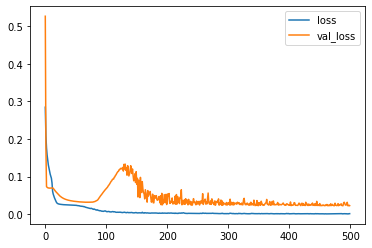

In [139]:
fig,ax=plt.subplots()
ax.plot(np.array(loss),label="loss")
ax.plot(np.array(val_loss),label="val_loss")      ## Attention, on a utilisé les données labelisees test
ax.legend();

In [140]:
hat_Y_test = model.model.predict(X_test)  
hat_Y_test.shape, hat_Y_test.max()

((82, 64, 64, 1), 0.7821716)

In [141]:
hat_Y_test = hat_Y_test[:,:,:,0]
Y_test.shape, hat_Y_test.shape

((82, 64, 64), (82, 64, 64))

In [142]:
# np.abs(hat_Y_test[0]- hat_Y_test[1]) <=1e-3

# print(hat_Y_test[0])
# print()
# print(hat_Y_test[2])

# print(Y_val.max())

In [149]:
lenTest = int(len(Y_test)/1)

fig,ax=plt.subplots(lenTest,2, figsize=(2*5,lenTest*5))

# vmin, vmax = 0, 1
vmin, vmax = None, None

for i in range(lenTest):
    # vmin, vmax = min([Y_test[i].min(), hat_Y_test[i].min()]), max([Y_test[i].max(), hat_Y_test[i].max()])   ## Une échelle particulière a chaque paire (true, predict) 
    vmin, vmax = min([Y_test[i].min()]), max([Y_test[i].max()])
    
    ax[i,0].imshow(Y_test[i], origin="lower", vmin=vmin, vmax=vmax)
    ax[i,1].imshow(hat_Y_test[i], origin="lower", vmin=vmin, vmax=vmax)

Output hidden; open in https://colab.research.google.com to view.

## Savegarde du model

In [144]:
# model.model.save("VNET01.h5")

In [145]:
# loaded_model = keras.models.load_model("VNET01.h5", custom_objects={"r2_score": r2_score}, compile=False)
# loaded_model.compile(optimizer=keras.optimizers.Adam(1e-5), loss=keras.losses.mse, metrics=[r2_score])

In [146]:
# print(loaded_model.summary())